In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/cephfs/home/lc865/workspace/similar-expressions')

## Analysis 1 - Plot Pareto volume and min loss over iteration for all runs (neural vs vanilla)

In [2]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

from src.SR_benchmarking.dataset import utils
from src.SR_benchmarking.analysis.utils import load_tensorboard_data

In [ ]:
# Define experiment directories for both vanilla and neural
experiment_dirs = {
    'neural': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-neural',
    'vanilla': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-vanilla'
    'neural-2': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-neural',
    'vanilla-2': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-vanilla'
    'neural-3': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-neural',
    'vanilla-3': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-vanilla'
}

# Load data from both experiments
data_by_experiment = {}
for experiment_type, experiment_dir in experiment_dirs.items():
        
    # Get all run directories with required prefix
    run_dirs = [d for d in os.listdir(experiment_dir) if os.path.isdir(os.path.join(experiment_dir, d)) and d.startswith("run")]
    
    # Load data from all runs
    data = []
    for run_dir in tqdm(run_dirs, desc=f"Loading {experiment_type} runs"):
        try:
            df_scalars, _ = load_tensorboard_data(os.path.join(experiment_dir, run_dir))
            df_scalars['run'] = run_dir
            data.append(df_scalars)  # [['step', 'timestamp', 'min_loss', 'pareto_volume', 'run']]
        except Exception as e:
            print(f"Error loading data for {run_dir}: {e}")
    
    data_by_experiment[experiment_type] = pd.concat(data, ignore_index=True)

# Store each dataframe in its respective directory
for experiment_type, df in data_by_experiment.items():
    output_path = os.path.join(experiment_dirs[experiment_type], f'tensorboard_scalars.csv')
    df.to_csv(output_path, index=False)
    print(f"Saved {experiment_type} data to {output_path}")


Loading neural runs:   0%|          | 0/60 [00:00<?, ?it/s]

Loading neural runs: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it]


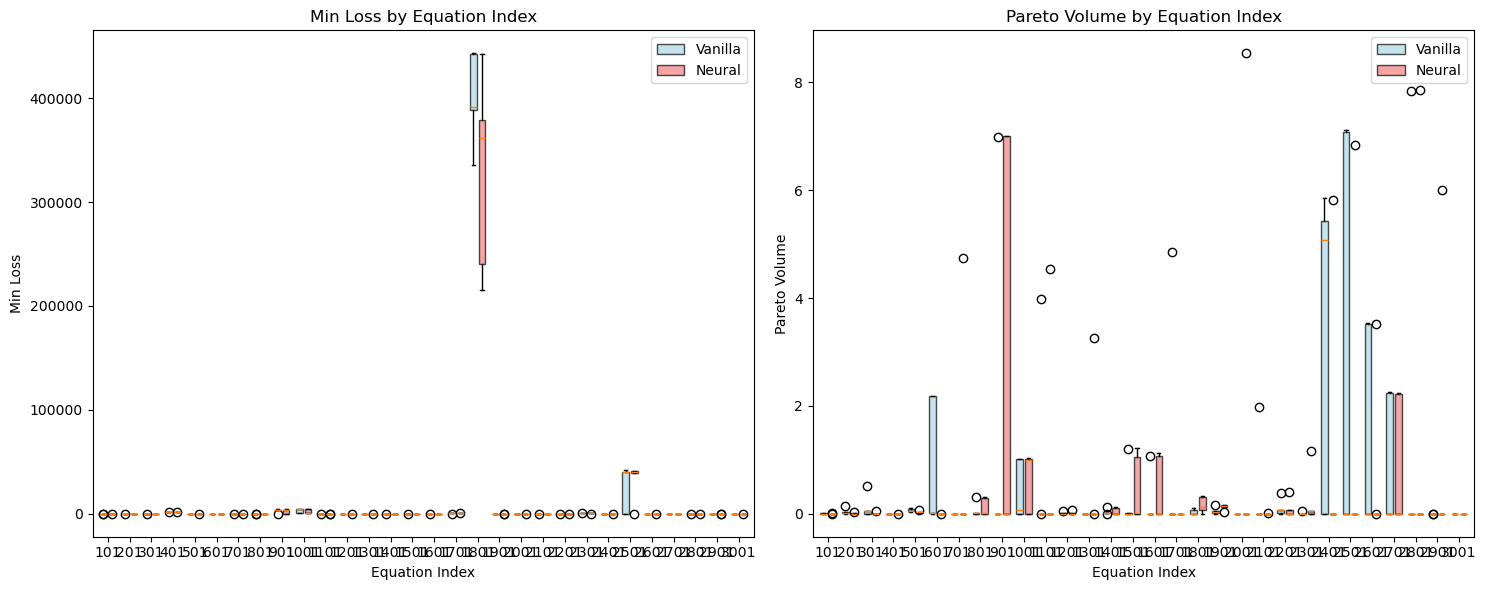

In [4]:
# Extract equation indices from run names for both experiments
df_final_vanilla = data_by_experiment['vanilla'].groupby('run').last().reset_index()
df_final_neural = data_by_experiment['neural'].groupby('run').last().reset_index()

# Extract equation indices from run names
df_final_vanilla['eq_idx'] = df_final_vanilla['run'].str.extract(r'eq(\d+)$').astype(int)
df_final_neural['eq_idx'] = df_final_neural['run'].str.extract(r'eq(\d+)$').astype(int)

# Add experiment type for plotting
df_final_vanilla['experiment'] = 'vanilla'
df_final_neural['experiment'] = 'neural'

# Combine both datasets
df_final_combined = pd.concat([df_final_vanilla, df_final_neural], ignore_index=True)

# Create boxplots for min_loss and pareto_volume by equation index
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot for min_loss - separate by experiment type
vanilla_data = df_final_vanilla.groupby('eq_idx')['min_loss'].apply(list).to_dict()
neural_data = df_final_neural.groupby('eq_idx')['min_loss'].apply(list).to_dict()

# Get all equation indices
all_eq_idx = sorted(set(df_final_vanilla['eq_idx'].unique()) | set(df_final_neural['eq_idx'].unique()))

# Prepare data for boxplot
vanilla_values = [vanilla_data.get(idx, []) for idx in all_eq_idx]
neural_values = [neural_data.get(idx, []) for idx in all_eq_idx]

# Create positions for boxplots
positions_vanilla = [i - 0.2 for i in range(len(all_eq_idx))]
positions_neural = [i + 0.2 for i in range(len(all_eq_idx))]

bp1 = ax1.boxplot(vanilla_values, positions=positions_vanilla, widths=0.3, patch_artist=True, 
                  boxprops=dict(facecolor='lightblue', alpha=0.7), label='Vanilla')
bp2 = ax1.boxplot(neural_values, positions=positions_neural, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightcoral', alpha=0.7), label='Neural')

ax1.set_title('Min Loss by Equation Index')
ax1.set_xlabel('Equation Index')
ax1.set_ylabel('Min Loss')
ax1.set_xticks(range(len(all_eq_idx)))
ax1.set_xticklabels(all_eq_idx)
ax1.legend()

# Boxplot for pareto_volume - separate by experiment type
vanilla_pv_data = df_final_vanilla.groupby('eq_idx')['pareto_volume'].apply(list).to_dict()
neural_pv_data = df_final_neural.groupby('eq_idx')['pareto_volume'].apply(list).to_dict()

vanilla_pv_values = [vanilla_pv_data.get(idx, []) for idx in all_eq_idx]
neural_pv_values = [neural_pv_data.get(idx, []) for idx in all_eq_idx]

bp3 = ax2.boxplot(vanilla_pv_values, positions=positions_vanilla, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7), label='Vanilla')
bp4 = ax2.boxplot(neural_pv_values, positions=positions_neural, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightcoral', alpha=0.7), label='Neural')

ax2.set_title('Pareto Volume by Equation Index')
ax2.set_xlabel('Equation Index')
ax2.set_ylabel('Pareto Volume')
ax2.set_xticks(range(len(all_eq_idx)))
ax2.set_xticklabels(all_eq_idx)
ax2.legend()

plt.tight_layout()
plt.show()

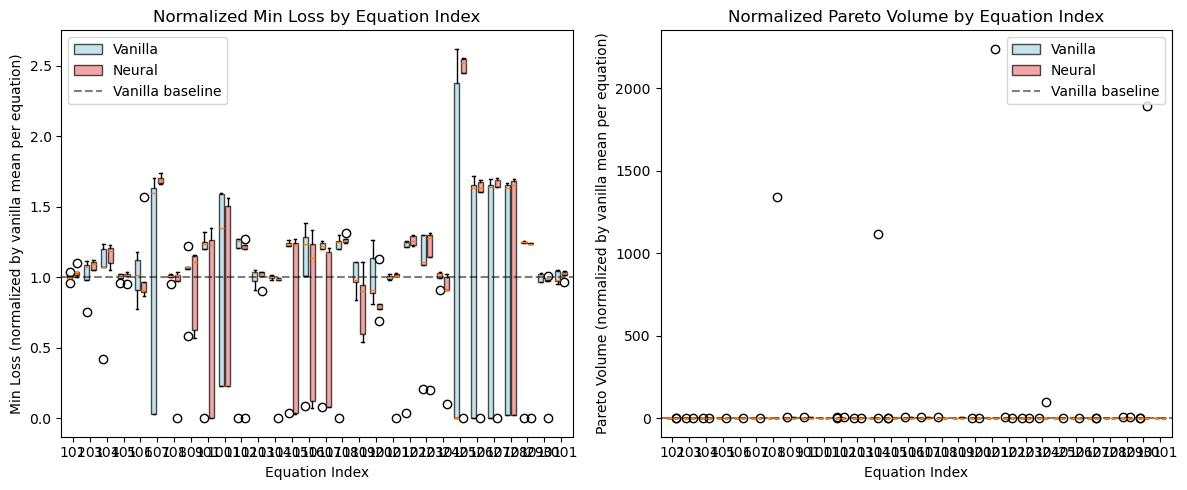

In [5]:
# Calculate mean vanilla scores for each equation for normalization
vanilla_mean_by_eq = df_final_vanilla.groupby('eq_idx')['min_loss'].mean()
vanilla_pv_mean_by_eq = df_final_vanilla.groupby('eq_idx')['pareto_volume'].mean()

# Normalize min_loss by vanilla mean for each equation
df_final_vanilla_norm = df_final_vanilla.copy()
df_final_neural_norm = df_final_neural.copy()

df_final_vanilla_norm['min_loss_normalized'] = df_final_vanilla_norm.apply(
    lambda row: row['min_loss'] / vanilla_mean_by_eq[row['eq_idx']], axis=1
)
df_final_neural_norm['min_loss_normalized'] = df_final_neural_norm.apply(
    lambda row: row['min_loss'] / vanilla_mean_by_eq[row['eq_idx']], axis=1
)

# Normalize pareto_volume by vanilla mean for each equation
df_final_vanilla_norm['pareto_volume_normalized'] = df_final_vanilla_norm.apply(
    lambda row: row['pareto_volume'] / vanilla_pv_mean_by_eq[row['eq_idx']], axis=1
)
df_final_neural_norm['pareto_volume_normalized'] = df_final_neural_norm.apply(
    lambda row: row['pareto_volume'] / vanilla_pv_mean_by_eq[row['eq_idx']], axis=1
)

# Create normalized boxplots by equation index
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Group normalized data by equation index
vanilla_norm_data = df_final_vanilla_norm.groupby('eq_idx')['min_loss_normalized'].apply(list).to_dict()
neural_norm_data = df_final_neural_norm.groupby('eq_idx')['min_loss_normalized'].apply(list).to_dict()

# Get all equation indices
all_eq_idx = sorted(set(df_final_vanilla_norm['eq_idx'].unique()) | set(df_final_neural_norm['eq_idx'].unique()))

# Prepare data for boxplot
vanilla_norm_values = [vanilla_norm_data.get(idx, []) for idx in all_eq_idx]
neural_norm_values = [neural_norm_data.get(idx, []) for idx in all_eq_idx]

# Create positions for boxplots
positions_vanilla = [i - 0.2 for i in range(len(all_eq_idx))]
positions_neural = [i + 0.2 for i in range(len(all_eq_idx))]

# Boxplot for normalized min_loss by equation
bp1 = ax1.boxplot(vanilla_norm_values, positions=positions_vanilla, widths=0.3, patch_artist=True, 
                  boxprops=dict(facecolor='lightblue', alpha=0.7), label='Vanilla')
bp2 = ax1.boxplot(neural_norm_values, positions=positions_neural, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightcoral', alpha=0.7), label='Neural')

ax1.set_title('Normalized Min Loss by Equation Index')
ax1.set_xlabel('Equation Index')
ax1.set_ylabel('Min Loss (normalized by vanilla mean per equation)')
ax1.set_xticks(range(len(all_eq_idx)))
ax1.set_xticklabels(all_eq_idx)
ax1.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Vanilla baseline')
ax1.legend()

# Boxplot for normalized pareto_volume by equation
vanilla_pv_norm_data = df_final_vanilla_norm.groupby('eq_idx')['pareto_volume_normalized'].apply(list).to_dict()
neural_pv_norm_data = df_final_neural_norm.groupby('eq_idx')['pareto_volume_normalized'].apply(list).to_dict()

vanilla_pv_norm_values = [vanilla_pv_norm_data.get(idx, []) for idx in all_eq_idx]
neural_pv_norm_values = [neural_pv_norm_data.get(idx, []) for idx in all_eq_idx]

bp3 = ax2.boxplot(vanilla_pv_norm_values, positions=positions_vanilla, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7), label='Vanilla')
bp4 = ax2.boxplot(neural_pv_norm_values, positions=positions_neural, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightcoral', alpha=0.7), label='Neural')

ax2.set_title('Normalized Pareto Volume by Equation Index')
ax2.set_xlabel('Equation Index')
ax2.set_ylabel('Pareto Volume (normalized by vanilla mean per equation)')
ax2.set_xticks(range(len(all_eq_idx)))
ax2.set_xticklabels(all_eq_idx)
ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Vanilla baseline')
ax2.legend()

plt.tight_layout()
plt.show()

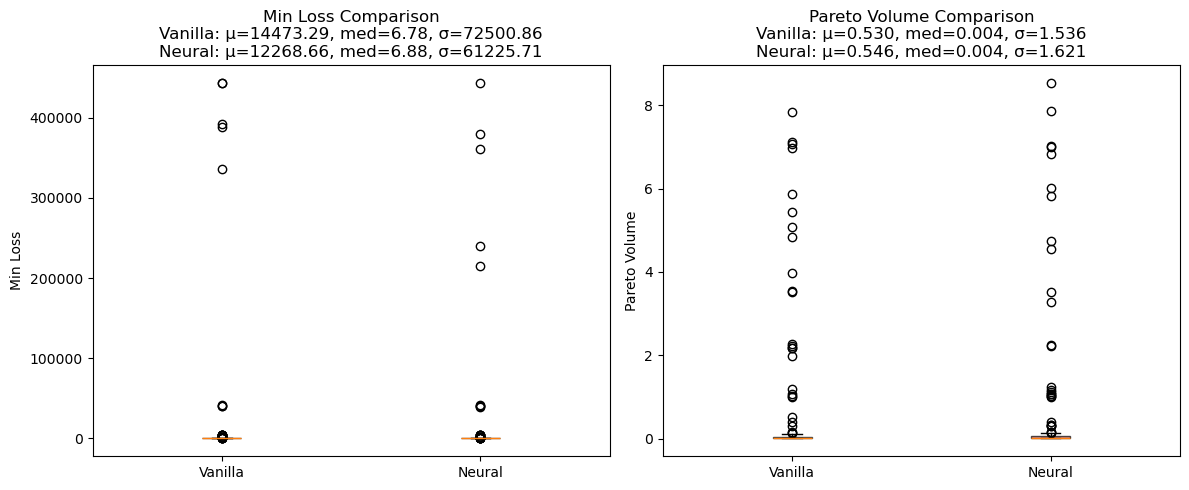

In [6]:
# Calculate mean min_loss and pareto_volume for vanilla and neural experiments
vanilla_mean_min_loss = df_final_vanilla['min_loss'].mean()
neural_mean_min_loss = df_final_neural['min_loss'].mean()
vanilla_median_min_loss = df_final_vanilla['min_loss'].median()
neural_median_min_loss = df_final_neural['min_loss'].median()
vanilla_std_min_loss = df_final_vanilla['min_loss'].std()
neural_std_min_loss = df_final_neural['min_loss'].std()

vanilla_mean_pareto_volume = df_final_vanilla['pareto_volume'].mean()
neural_mean_pareto_volume = df_final_neural['pareto_volume'].mean()
vanilla_median_pareto_volume = df_final_vanilla['pareto_volume'].median()
neural_median_pareto_volume = df_final_neural['pareto_volume'].median()
vanilla_std_pareto_volume = df_final_vanilla['pareto_volume'].std()
neural_std_pareto_volume = df_final_neural['pareto_volume'].std()

# Create boxplots comparing vanilla vs neural
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot for min_loss
bp1 = ax1.boxplot([df_final_vanilla['min_loss'], df_final_neural['min_loss']], 
                  tick_labels=['Vanilla', 'Neural'],
                  patch_artist=True)
bp1['boxes'][0].set_facecolor('lightblue')
bp1['boxes'][0].set_alpha(0.7)
bp1['boxes'][1].set_facecolor('lightcoral')
bp1['boxes'][1].set_alpha(0.7)
ax1.set_title(f'Min Loss Comparison\nVanilla: μ={vanilla_mean_min_loss:.2f}, med={vanilla_median_min_loss:.2f}, σ={vanilla_std_min_loss:.2f}\nNeural: μ={neural_mean_min_loss:.2f}, med={neural_median_min_loss:.2f}, σ={neural_std_min_loss:.2f}')
ax1.set_ylabel('Min Loss')

# Boxplot for pareto_volume
bp2 = ax2.boxplot([df_final_vanilla['pareto_volume'], df_final_neural['pareto_volume']], 
                  tick_labels=['Vanilla', 'Neural'],
                  patch_artist=True)
bp2['boxes'][0].set_facecolor('lightblue')
bp2['boxes'][0].set_alpha(0.7)
bp2['boxes'][1].set_facecolor('lightcoral')
bp2['boxes'][1].set_alpha(0.7)
ax2.set_title(f'Pareto Volume Comparison\nVanilla: μ={vanilla_mean_pareto_volume:.3f}, med={vanilla_median_pareto_volume:.3f}, σ={vanilla_std_pareto_volume:.3f}\nNeural: μ={neural_mean_pareto_volume:.3f}, med={neural_median_pareto_volume:.3f}, σ={neural_std_pareto_volume:.3f}')
ax2.set_ylabel('Pareto Volume')

plt.tight_layout()
plt.show()


/tmp/ipykernel_47851/3798373553.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_loss['eq_idx'] = df_min_loss['run'].str.extract(r'eq(\d+)$').astype(int)


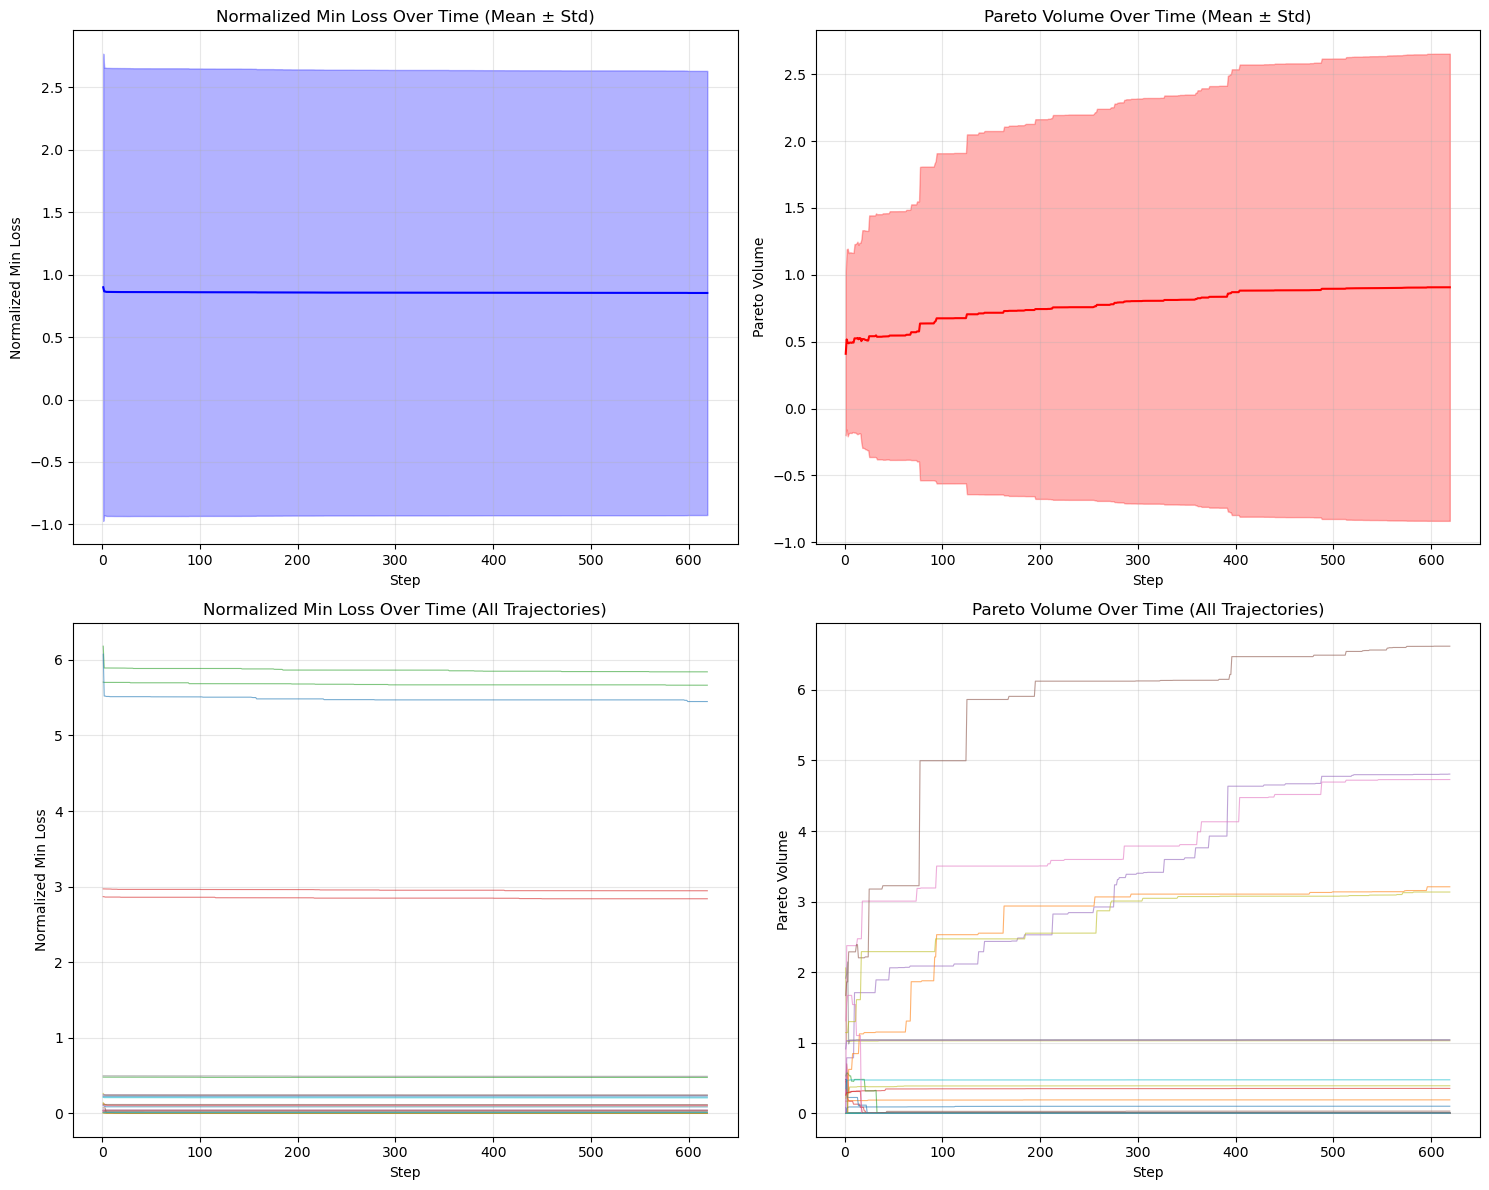

In [7]:
# Load dataset for normalization
dataset_path = "/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking/dataset/PySR-difficultEquations.csv"
df_dataset = pd.read_csv(dataset_path)

# Extract equation indices and merge with dataset
df_min_loss['eq_idx'] = df_min_loss['run'].str.extract(r'eq(\d+)$').astype(int)
df_min_loss_with_std = pd.merge(df_min_loss, df_dataset.reset_index().rename(columns={'index': 'eq_idx'})[['eq_idx', 'true_stdev']], 
                                on='eq_idx', how='left')

# Normalize min_loss by true_stdev
df_min_loss_with_std['normalized_min_loss'] = df_min_loss_with_std['min_loss'] / df_min_loss_with_std['true_stdev'].apply(lambda x: max(1, x))

# Calculate statistics
normalized_min_loss_stats = df_min_loss_with_std.groupby('step')['normalized_min_loss'].agg(['mean', 'std']).reset_index()
pareto_volume_stats = df_pareto_volume.groupby('step')['pareto_volume'].agg(['mean', 'std']).reset_index()

# Create 2x2 subplot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot normalized min_loss mean ± std
ax1.plot(normalized_min_loss_stats['step'], normalized_min_loss_stats['mean'], color='blue')
ax1.fill_between(normalized_min_loss_stats['step'], 
                 normalized_min_loss_stats['mean'] - normalized_min_loss_stats['std'],
                 normalized_min_loss_stats['mean'] + normalized_min_loss_stats['std'],
                 alpha=0.3, color='blue')
ax1.set_xlabel('Step')
ax1.set_ylabel('Normalized Min Loss')
ax1.set_title('Normalized Min Loss Over Time (Mean ± Std)')
ax1.grid(True, alpha=0.3)

# Plot pareto_volume mean ± std
ax2.plot(pareto_volume_stats['step'], pareto_volume_stats['mean'], color='red')
ax2.fill_between(pareto_volume_stats['step'], 
                 pareto_volume_stats['mean'] - pareto_volume_stats['std'],
                 pareto_volume_stats['mean'] + pareto_volume_stats['std'],
                 alpha=0.3, color='red')
ax2.set_xlabel('Step')
ax2.set_ylabel('Pareto Volume')
ax2.set_title('Pareto Volume Over Time (Mean ± Std)')
ax2.grid(True, alpha=0.3)

# Plot all individual trajectories
for run in df_min_loss_with_std['run'].unique():
    run_data = df_min_loss_with_std[df_min_loss_with_std['run'] == run]
    ax3.plot(run_data['step'], run_data['normalized_min_loss'], alpha=0.6, linewidth=0.8)
ax3.set_xlabel('Step')
ax3.set_ylabel('Normalized Min Loss')
ax3.set_title('Normalized Min Loss Over Time (All Trajectories)')
ax3.grid(True, alpha=0.3)

for run in df_pareto_volume['run'].unique():
    run_data = df_pareto_volume[df_pareto_volume['run'] == run]
    ax4.plot(run_data['step'], run_data['pareto_volume'], alpha=0.6, linewidth=0.8)
ax4.set_xlabel('Step')
ax4.set_ylabel('Pareto Volume')
ax4.set_title('Pareto Volume Over Time (All Trajectories)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

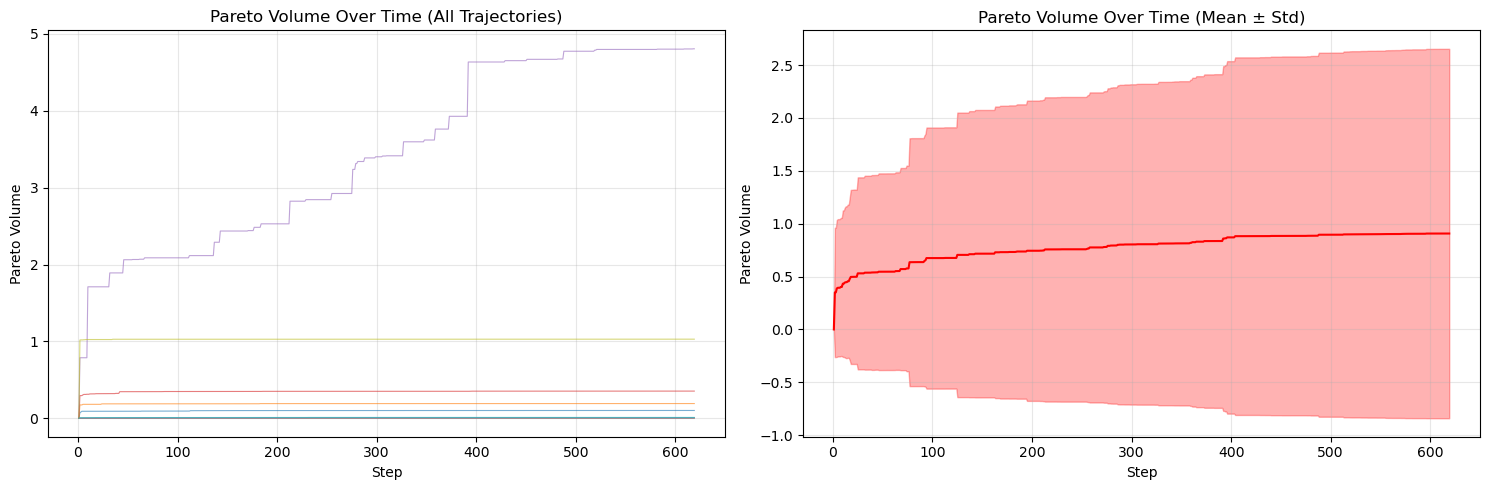

In [8]:
# Preprocess pareto volume data
# Replace first timestep with 0 and ensure monotonically decreasing from back to front

# Find the maximum number of steps across all runs
max_steps = df_pareto_volume.groupby('run')['step'].max().max()

# Create a list to store processed data
processed_data = []

for run in df_pareto_volume['run'].unique():
    run_data = df_pareto_volume[df_pareto_volume['run'] == run].copy()
    run_data = run_data.sort_values('step').reset_index(drop=True)
    
    # Replace first timestep with 0
    run_data.loc[0, 'pareto_volume'] = 0
    
    # Get the last pareto_volume value
    last_value = run_data['pareto_volume'].iloc[-1]
    last_step = run_data['step'].max()
    
    # Fill missing steps with the last value
    if last_step < max_steps:
        missing_steps = range(last_step + 1, max_steps + 1)
        for step in missing_steps:
            new_row = {'step': step, 'pareto_volume': last_value, 'run': run}
            run_data = pd.concat([run_data, pd.DataFrame([new_row])], ignore_index=True)
    
    # Ensure monotonically decreasing from back to front (vectorized)
    # Traverse from back to front and replace increases with previous value
    pareto_values = run_data['pareto_volume'].values
    for i in range(len(pareto_values) - 2, -1, -1):
        if pareto_values[i] > pareto_values[i + 1]:
            pareto_values[i] = pareto_values[i + 1]
    run_data['pareto_volume'] = pareto_values
    
    processed_data.append(run_data)

# Combine all processed data
df_pareto_volume_processed = pd.concat(processed_data, ignore_index=True)

# Update the original dataframe
df_pareto_volume = df_pareto_volume_processed

# Calculate stats for processed data
pareto_volume_stats = df_pareto_volume.groupby('step')['pareto_volume'].agg(['mean', 'std']).reset_index()

# Plot trajectories and mean ± std
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot all individual trajectories
for run in df_pareto_volume['run'].unique()[:10]:
    run_data = df_pareto_volume[df_pareto_volume['run'] == run]
    ax1.plot(run_data['step'], run_data['pareto_volume'], alpha=0.6, linewidth=0.8)
ax1.set_xlabel('Step')
ax1.set_ylabel('Pareto Volume')
ax1.set_title('Pareto Volume Over Time (All Trajectories)')
ax1.grid(True, alpha=0.3)

# Plot mean ± std
ax2.plot(pareto_volume_stats['step'], pareto_volume_stats['mean'], color='red')
ax2.fill_between(pareto_volume_stats['step'], 
                 pareto_volume_stats['mean'] - pareto_volume_stats['std'],
                 pareto_volume_stats['mean'] + pareto_volume_stats['std'],
                 alpha=0.3, color='red')
ax2.set_xlabel('Step')
ax2.set_ylabel('Pareto Volume')
ax2.set_title('Pareto Volume Over Time (Mean ± Std)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot pareto volume over timestamp for a specific run
run_name = 'run0_pysr-difficult_eq601'

single_run_data = df_combined[df_combined['run'] == run_name]

plt.figure(figsize=(10, 6))
plt.plot(single_run_data['step'], single_run_data['pareto_volume'])
plt.xlabel('Timestep')
plt.ylabel('Pareto Volume')
plt.title(f'Pareto Volume Over Time - {run_name}')
# plt.xlim(0, 10)
plt.yscale('log')
plt.show()


In [ ]:
# Plot a single pareto volume curve for one run
run_name = 'run0_pysr-difficult_eq601'  # Get the third run
single_run_data = df_pareto_volume[df_pareto_volume['run'] == run_name]

plt.figure(figsize=(10, 6))
plt.plot(single_run_data['step'], single_run_data['pareto_volume'])
plt.xlabel('Step')
plt.ylabel('Pareto Volume')
plt.title(f'Pareto Volume Over Time - {run_name}')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Extract equation indices from run names and calculate mean loss for each equation
df_min_loss['eq_idx'] = df_min_loss['run'].str.extract(r'eq(\d+)$').astype(int)

# Calculate the final min loss for each run (last step)
final_losses = df_min_loss.groupby('run')['min_loss'].last().reset_index()
final_losses['eq_idx'] = final_losses['run'].str.extract(r'eq(\d+)$').astype(int)

# Calculate mean loss for each equation index
mean_losses_by_eq = final_losses.groupby('eq_idx')['min_loss'].mean().reset_index()

# Create scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(mean_losses_by_eq['eq_idx'], mean_losses_by_eq['min_loss'], alpha=0.7, s=50)
plt.xlabel('Equation Index')
plt.ylabel('Mean Final Loss')
plt.title('Mean Final Loss by Equation Index')
plt.grid(True, alpha=0.3)
plt.show()

print("Mean losses by equation index:")
print(mean_losses_by_eq.head(10))


In [ ]:
# Load the dataset
dataset_path = "/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking/dataset/PySR-difficultEquations.csv"
df_dataset = pd.read_csv(dataset_path)

print("Dataset columns:", df_dataset.columns.tolist())
print("Dataset shape:", df_dataset.shape)
print("\nFirst few rows:")
print(df_dataset.head())

# Merge with mean losses by equation index
df_merged = pd.merge(mean_losses_by_eq, df_dataset.reset_index().rename(columns={'index': 'eq_idx'}), 
                     on='eq_idx', how='inner')

print(f"\nMerged dataset shape: {df_merged.shape}")

# Get numerical columns (excluding true_equation)
numerical_cols = [col for col in df_dataset.columns if col != 'true_equation' and pd.api.types.is_numeric_dtype(df_dataset[col])]
print(f"Numerical columns to plot: {numerical_cols}")

# Create scatter plots
n_cols = len(numerical_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))
if n_cols == 1:
    axes = [axes]

for i, col in enumerate(numerical_cols):
    axes[i].scatter(df_merged[col], df_merged['min_loss'], alpha=0.7, s=50)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Mean Final Loss')
    axes[i].set_title(f'Mean Final Loss vs {col}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation matrix
print("\nCorrelation with mean final loss:")
correlations = df_merged[numerical_cols + ['min_loss']].corr()['min_loss'].drop('min_loss').sort_values(key=abs, ascending=False)
print(correlations)


In [ ]:
# Create lin-lin plots for mean final loss vs true_stdev and true_stdev^2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Mean final loss vs true_stdev (lin-lin)
axes[0].scatter(df_merged['true_stdev'], df_merged['min_loss'], alpha=0.7, s=50)
axes[0].set_xlabel('True Standard Deviation')
axes[0].set_ylabel('Mean Final Loss')
axes[0].set_title('Mean Final Loss vs True Standard Deviation')
axes[0].grid(True, alpha=0.3)

# Plot 2: Mean final loss vs true_stdev^2 (lin-lin)
axes[1].scatter(df_merged['true_stdev']**2, df_merged['min_loss'], alpha=0.7, s=50, color='orange')
axes[1].set_xlabel('True Standard Deviation²')
axes[1].set_ylabel('Mean Final Loss')
axes[1].set_title('Mean Final Loss vs True Standard Deviation²')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlations for linear values
print("Linear correlations:")
corr_stdev = np.corrcoef(df_merged['true_stdev'], df_merged['min_loss'])[0, 1]
corr_stdev_sq = np.corrcoef(df_merged['true_stdev']**2, df_merged['min_loss'])[0, 1]

print(f"true_stdev vs min_loss: {corr_stdev:.4f}")
print(f"true_stdev² vs min_loss: {corr_stdev_sq:.4f}")


## Choosing equations to benchmark on

In [7]:
dataset_path = "/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking/dataset/PySR-difficultEquations.csv"
df = pd.read_csv(dataset_path)

In [8]:
df.head()

,true_complexity,true_equation,true_stdev,found_loss,found_equation
0,21,(((x2 / (-1.3121885226142032 / x2)) + x4) * (...,283.673073,33387.265284,x5 + (((-16.11852913836739 + (((log(x5) + (co...
1,26,(0.889758134323455 - cos((-0.5579692881660584...,355.518202,22329.841090,(((1.8677049149506384 - cos(x2 - cos(x1 - 0.5...
2,23,(x2 * x2) * (((0.9818400804070693 * ((x3 + x2...,825.966943,5883.247353,((-1.6318942576986628 + x2) * (((sqrt((exp(x4...
3,27,((0.5255544538253518 - x3) * ((cos(cos(-1.314...,151.023472,1189.755783,((((cos(x2) + -0.4530478100051937) + (cos(3.4...
4,25,((sqrt(x2) * (((2.1550832986870465 - x4) - sq...,795.094477,1173.316845,(((((x3 - (6.023439009123716 - (3.92547134853...


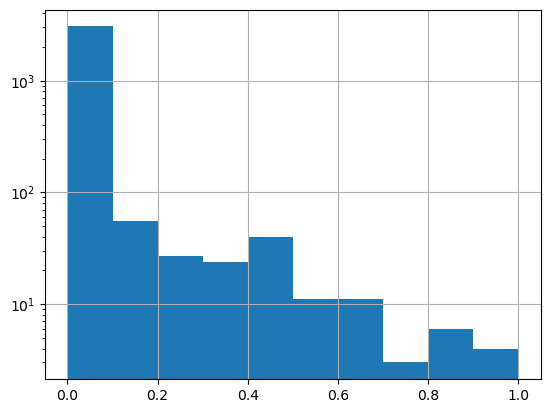

In [9]:
df.found_loss.hist(range=(0, 1))
plt.yscale('log')

<Axes: >

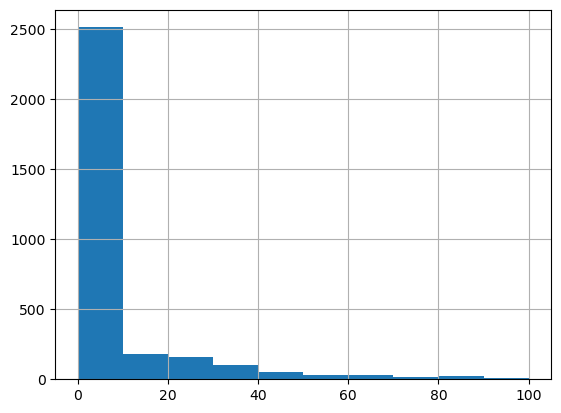

In [10]:
df.true_stdev.hist(range=(0, 100))

<Axes: >

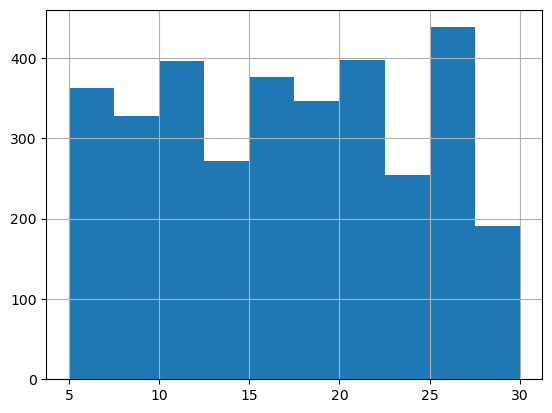

In [11]:
df.true_complexity.hist()

In [26]:
mask = (df.true_complexity < 20) & (df.true_stdev < 10)  & (df.found_loss < 0.2) & (~df.true_equation.str.contains('log'))
print(f"Fraction of equations: {mask.mean()*100:.1f}%")

currently_chosen = np.zeros_like(mask)
start_idx = 103
currently_chosen[np.arange(start_idx, 3000+start_idx-99, 100)] = 1
# currently_chosen[np.arange(2000, 3000)] = 1

(currently_chosen & mask).sum()/currently_chosen.sum()

Fraction of equations: 31.4%


np.float64(0.16666666666666666)

In [27]:
eqns_of_interest = np.where(currently_chosen)[0]
eqns_of_interest

array([ 103,  203,  303,  403,  503,  603,  703,  803,  903, 1003, 1103,
       1203, 1303, 1403, 1503, 1603, 1703, 1803, 1903, 2003, 2103, 2203,
       2303, 2403, 2503, 2603, 2703, 2803, 2903, 3003])

In [57]:
pd.set_option('display.max_colwidth', None)
df.loc[eqns_of_interest]['true_equation']

101      ((log(x4) + 0.028516294341771057) + (x5 / (-1.9044457451687498 / x2))) * cos((1.091967721135441 + exp(-1.0855497792043463 - x5)) * ((x4 * x2) * (cos(x3) - 0.135662220670991)))                                                                           
201      cos(x2 * cos(x1)) / (sqrt(x1) + (x1 - cos(x2)))                                                                                                                                                                                                           
301      (exp(exp(x1 / -0.6026808576490582) + cos(x2 / -1.2568772889379043)) * (x2 - x1)) - ((x2 - 0.27574533805506457) / 0.8819864633174935)                                                                                                                      
401      cos(cos(x1 / (-1.3927370953533718 / (x1 + x1)))) / ((0.6143887793158074 / x1) / (sqrt(exp(x2 / x2)) + ((0.30970406462171757 + (x1 + -0.1421955807198712)) - 0.6408918880383424)))                                  

## Analysis using equation metadata

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

experiment_dirs = {
    'neural': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-neural',
    'vanilla': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-vanilla',
    'neural-2': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-2-neural',
    'vanilla-2': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-2-vanilla',
    'neural-3': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-3-neural',
    'vanilla-3': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-3-vanilla'
}

In [6]:
dataset_path = "/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking/dataset/PySR-difficultEquations.csv"
df = pd.read_csv(dataset_path)
df.head()

,true_complexity,true_equation,true_stdev,found_loss,found_equation
0,21,(((x2 / (-1.3121885226142032 / x2)) + x4) * (...,283.673073,33387.265284,x5 + (((-16.11852913836739 + (((log(x5) + (co...
1,26,(0.889758134323455 - cos((-0.5579692881660584...,355.518202,22329.841090,(((1.8677049149506384 - cos(x2 - cos(x1 - 0.5...
2,23,(x2 * x2) * (((0.9818400804070693 * ((x3 + x2...,825.966943,5883.247353,((-1.6318942576986628 + x2) * (((sqrt((exp(x4...
3,27,((0.5255544538253518 - x3) * ((cos(cos(-1.314...,151.023472,1189.755783,((((cos(x2) + -0.4530478100051937) + (cos(3.4...
4,25,((sqrt(x2) * (((2.1550832986870465 - x4) - sq...,795.094477,1173.316845,(((((x3 - (6.023439009123716 - (3.92547134853...


In [24]:
# Load data from tensorboard_scalars.csv files
data_by_experiment = {}
for exp_name, exp_dir in experiment_dirs.items():
    csv_path = f"{exp_dir}/tensorboard_scalars.csv"
    data_by_experiment[exp_name] = pd.read_csv(csv_path)[['run', 'timestamp', 'step', 'min_loss', 'pareto_volume', 'num_evals']]

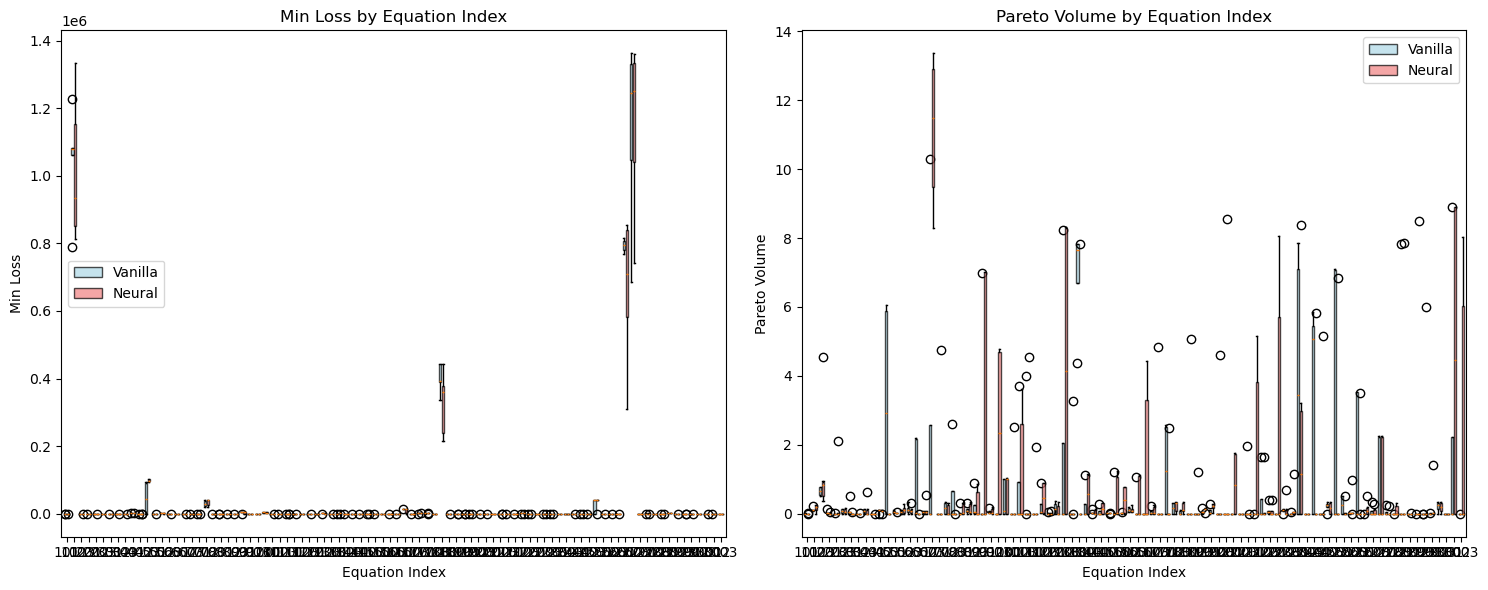

In [25]:
# Extract equation indices from run names for both experiments
df_final_vanilla = data_by_experiment['vanilla-3'].groupby('run').last().reset_index()
df_final_neural = data_by_experiment['neural-3'].groupby('run').last().reset_index()

# Extract equation indices from run names
df_final_vanilla['eq_idx'] = df_final_vanilla['run'].str.extract(r'eq(\d+)$').astype(int)
df_final_neural['eq_idx'] = df_final_neural['run'].str.extract(r'eq(\d+)$').astype(int)

# Add experiment type for plotting
df_final_vanilla['experiment'] = 'vanilla'
df_final_neural['experiment'] = 'neural'

# Combine both datasets
df_final_combined = pd.concat([df_final_vanilla, df_final_neural], ignore_index=True)

# Create boxplots for min_loss and pareto_volume by equation index
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot for min_loss - separate by experiment type
vanilla_data = df_final_vanilla.groupby('eq_idx')['min_loss'].apply(list).to_dict()
neural_data = df_final_neural.groupby('eq_idx')['min_loss'].apply(list).to_dict()

# Get all equation indices
all_eq_idx = sorted(set(df_final_vanilla['eq_idx'].unique()) | set(df_final_neural['eq_idx'].unique()))

# Prepare data for boxplot
vanilla_values = [vanilla_data.get(idx, []) for idx in all_eq_idx]
neural_values = [neural_data.get(idx, []) for idx in all_eq_idx]

# Create positions for boxplots
positions_vanilla = [i - 0.2 for i in range(len(all_eq_idx))]
positions_neural = [i + 0.2 for i in range(len(all_eq_idx))]

bp1 = ax1.boxplot(vanilla_values, positions=positions_vanilla, widths=0.3, patch_artist=True, 
                  boxprops=dict(facecolor='lightblue', alpha=0.7), label='Vanilla')
bp2 = ax1.boxplot(neural_values, positions=positions_neural, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightcoral', alpha=0.7), label='Neural')

ax1.set_title('Min Loss by Equation Index')
ax1.set_xlabel('Equation Index')
ax1.set_ylabel('Min Loss')
ax1.set_xticks(range(len(all_eq_idx)))
ax1.set_xticklabels(all_eq_idx)
ax1.legend()

# Boxplot for pareto_volume - separate by experiment type
vanilla_pv_data = df_final_vanilla.groupby('eq_idx')['pareto_volume'].apply(list).to_dict()
neural_pv_data = df_final_neural.groupby('eq_idx')['pareto_volume'].apply(list).to_dict()

vanilla_pv_values = [vanilla_pv_data.get(idx, []) for idx in all_eq_idx]
neural_pv_values = [neural_pv_data.get(idx, []) for idx in all_eq_idx]

bp3 = ax2.boxplot(vanilla_pv_values, positions=positions_vanilla, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7), label='Vanilla')
bp4 = ax2.boxplot(neural_pv_values, positions=positions_neural, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightcoral', alpha=0.7), label='Neural')

ax2.set_title('Pareto Volume by Equation Index')
ax2.set_xlabel('Equation Index')
ax2.set_ylabel('Pareto Volume')
ax2.set_xticks(range(len(all_eq_idx)))
ax2.set_xticklabels(all_eq_idx)
ax2.legend()

plt.tight_layout()
plt.show()

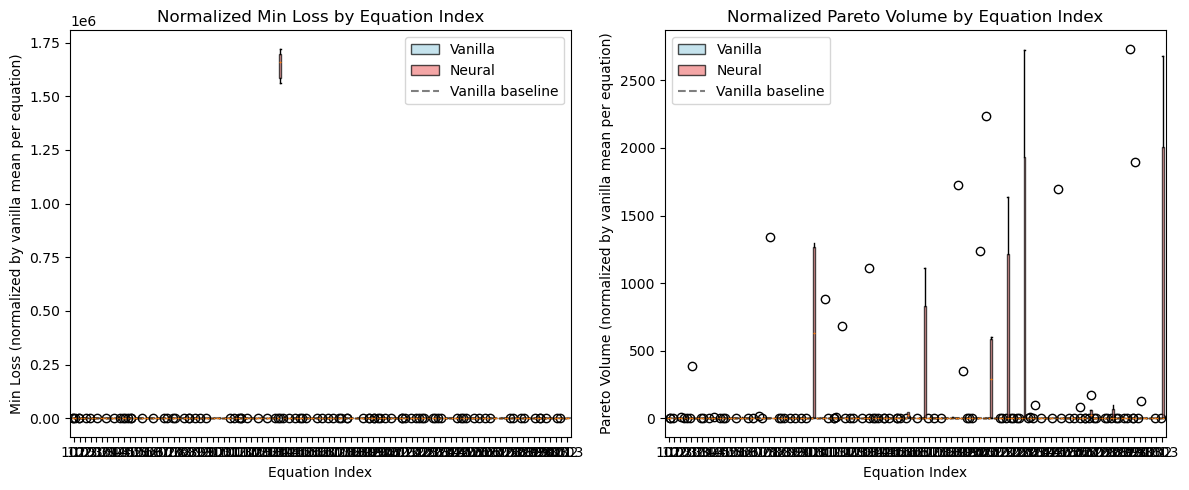

In [26]:
# Calculate mean vanilla scores for each equation for normalization
vanilla_mean_by_eq = df_final_vanilla.groupby('eq_idx')['min_loss'].mean()
vanilla_pv_mean_by_eq = df_final_vanilla.groupby('eq_idx')['pareto_volume'].mean()

# Normalize min_loss by vanilla mean for each equation
df_final_vanilla_norm = df_final_vanilla.copy()
df_final_neural_norm = df_final_neural.copy()

df_final_vanilla_norm['min_loss_normalized'] = df_final_vanilla_norm.apply(
    lambda row: row['min_loss'] / vanilla_mean_by_eq[row['eq_idx']], axis=1
)
df_final_neural_norm['min_loss_normalized'] = df_final_neural_norm.apply(
    lambda row: row['min_loss'] / vanilla_mean_by_eq[row['eq_idx']], axis=1
)

# Normalize pareto_volume by vanilla mean for each equation
df_final_vanilla_norm['pareto_volume_normalized'] = df_final_vanilla_norm.apply(
    lambda row: row['pareto_volume'] / vanilla_pv_mean_by_eq[row['eq_idx']], axis=1
)
df_final_neural_norm['pareto_volume_normalized'] = df_final_neural_norm.apply(
    lambda row: row['pareto_volume'] / vanilla_pv_mean_by_eq[row['eq_idx']], axis=1
)

# Create normalized boxplots by equation index
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Group normalized data by equation index
vanilla_norm_data = df_final_vanilla_norm.groupby('eq_idx')['min_loss_normalized'].apply(list).to_dict()
neural_norm_data = df_final_neural_norm.groupby('eq_idx')['min_loss_normalized'].apply(list).to_dict()

# Get all equation indices
all_eq_idx = sorted(set(df_final_vanilla_norm['eq_idx'].unique()) | set(df_final_neural_norm['eq_idx'].unique()))

# Prepare data for boxplot
vanilla_norm_values = [vanilla_norm_data.get(idx, []) for idx in all_eq_idx]
neural_norm_values = [neural_norm_data.get(idx, []) for idx in all_eq_idx]

# Create positions for boxplots
positions_vanilla = [i - 0.2 for i in range(len(all_eq_idx))]
positions_neural = [i + 0.2 for i in range(len(all_eq_idx))]

# Boxplot for normalized min_loss by equation
bp1 = ax1.boxplot(vanilla_norm_values, positions=positions_vanilla, widths=0.3, patch_artist=True, 
                  boxprops=dict(facecolor='lightblue', alpha=0.7), label='Vanilla')
bp2 = ax1.boxplot(neural_norm_values, positions=positions_neural, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightcoral', alpha=0.7), label='Neural')

ax1.set_title('Normalized Min Loss by Equation Index')
ax1.set_xlabel('Equation Index')
ax1.set_ylabel('Min Loss (normalized by vanilla mean per equation)')
ax1.set_xticks(range(len(all_eq_idx)))
ax1.set_xticklabels(all_eq_idx)
ax1.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Vanilla baseline')
ax1.legend()

# Boxplot for normalized pareto_volume by equation
vanilla_pv_norm_data = df_final_vanilla_norm.groupby('eq_idx')['pareto_volume_normalized'].apply(list).to_dict()
neural_pv_norm_data = df_final_neural_norm.groupby('eq_idx')['pareto_volume_normalized'].apply(list).to_dict()

vanilla_pv_norm_values = [vanilla_pv_norm_data.get(idx, []) for idx in all_eq_idx]
neural_pv_norm_values = [neural_pv_norm_data.get(idx, []) for idx in all_eq_idx]

bp3 = ax2.boxplot(vanilla_pv_norm_values, positions=positions_vanilla, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7), label='Vanilla')
bp4 = ax2.boxplot(neural_pv_norm_values, positions=positions_neural, widths=0.3, patch_artist=True,
                  boxprops=dict(facecolor='lightcoral', alpha=0.7), label='Neural')

ax2.set_title('Normalized Pareto Volume by Equation Index')
ax2.set_xlabel('Equation Index')
ax2.set_ylabel('Pareto Volume (normalized by vanilla mean per equation)')
ax2.set_xticks(range(len(all_eq_idx)))
ax2.set_xticklabels(all_eq_idx)
ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Vanilla baseline')
ax2.legend()

plt.tight_layout()
plt.show()

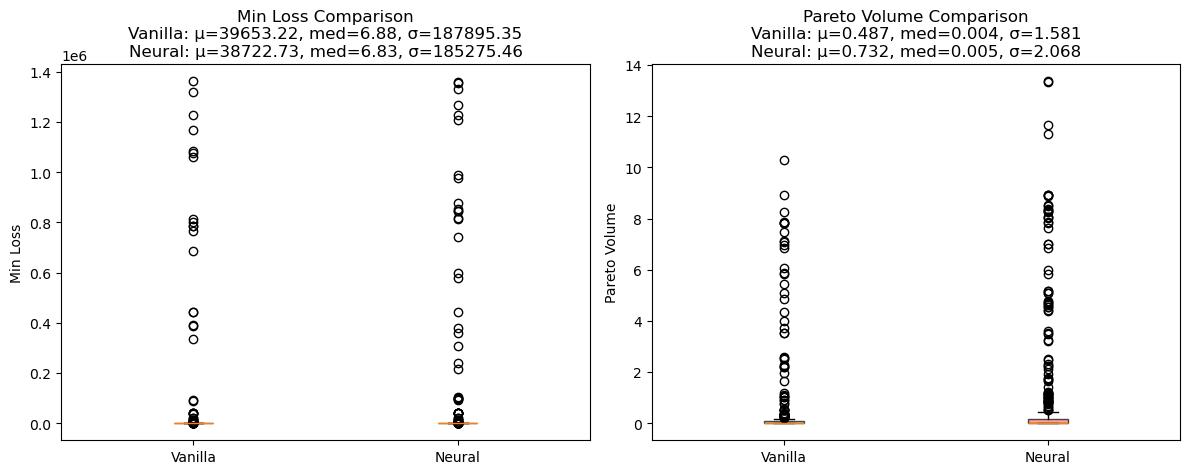

In [27]:
# Calculate mean min_loss and pareto_volume for vanilla and neural experiments
vanilla_mean_min_loss = df_final_vanilla['min_loss'].mean()
neural_mean_min_loss = df_final_neural['min_loss'].mean()
vanilla_median_min_loss = df_final_vanilla['min_loss'].median()
neural_median_min_loss = df_final_neural['min_loss'].median()
vanilla_std_min_loss = df_final_vanilla['min_loss'].std()
neural_std_min_loss = df_final_neural['min_loss'].std()

vanilla_mean_pareto_volume = df_final_vanilla['pareto_volume'].mean()
neural_mean_pareto_volume = df_final_neural['pareto_volume'].mean()
vanilla_median_pareto_volume = df_final_vanilla['pareto_volume'].median()
neural_median_pareto_volume = df_final_neural['pareto_volume'].median()
vanilla_std_pareto_volume = df_final_vanilla['pareto_volume'].std()
neural_std_pareto_volume = df_final_neural['pareto_volume'].std()

# Create boxplots comparing vanilla vs neural
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot for min_loss
bp1 = ax1.boxplot([df_final_vanilla['min_loss'], df_final_neural['min_loss']], 
                  tick_labels=['Vanilla', 'Neural'],
                  patch_artist=True)
bp1['boxes'][0].set_facecolor('lightblue')
bp1['boxes'][0].set_alpha(0.7)
bp1['boxes'][1].set_facecolor('lightcoral')
bp1['boxes'][1].set_alpha(0.7)
ax1.set_title(f'Min Loss Comparison\nVanilla: μ={vanilla_mean_min_loss:.2f}, med={vanilla_median_min_loss:.2f}, σ={vanilla_std_min_loss:.2f}\nNeural: μ={neural_mean_min_loss:.2f}, med={neural_median_min_loss:.2f}, σ={neural_std_min_loss:.2f}')
ax1.set_ylabel('Min Loss')

# Boxplot for pareto_volume
bp2 = ax2.boxplot([df_final_vanilla['pareto_volume'], df_final_neural['pareto_volume']], 
                  tick_labels=['Vanilla', 'Neural'],
                  patch_artist=True)
bp2['boxes'][0].set_facecolor('lightblue')
bp2['boxes'][0].set_alpha(0.7)
bp2['boxes'][1].set_facecolor('lightcoral')
bp2['boxes'][1].set_alpha(0.7)
ax2.set_title(f'Pareto Volume Comparison\nVanilla: μ={vanilla_mean_pareto_volume:.3f}, med={vanilla_median_pareto_volume:.3f}, σ={vanilla_std_pareto_volume:.3f}\nNeural: μ={neural_mean_pareto_volume:.3f}, med={neural_median_pareto_volume:.3f}, σ={neural_std_pareto_volume:.3f}')
ax2.set_ylabel('Pareto Volume')

plt.tight_layout()
plt.show()


In [28]:
df_final_vanilla

,run,timestamp,step,min_loss,pareto_volume,num_evals,eq_idx,experiment
0,run0_pysr-difficult_eq1001,1.757208e+09,619,7.070928e+02,1.008600,599321.0,1001,vanilla
1,run0_pysr-difficult_eq101,1.757208e+09,619,1.564459e+02,0.004226,586319.0,101,vanilla
2,run0_pysr-difficult_eq1101,1.757208e+09,619,5.065252e-02,0.003079,528291.0,1101,vanilla
3,run0_pysr-difficult_eq1201,1.757208e+09,619,2.902933e-01,0.002102,540995.0,1201,vanilla
4,run0_pysr-difficult_eq1301,1.757208e+09,619,6.805839e-02,0.002227,518802.0,1301,vanilla
...,...,...,...,...,...,...,...,...
386,run8_pysr-difficult_eq802,1.757319e+09,619,1.255301e+02,0.078770,566669.0,802,vanilla
387,run8_pysr-difficult_eq803,1.757320e+09,619,4.480684e+00,0.039457,541806.0,803,vanilla
388,run8_pysr-difficult_eq902,1.757319e+09,619,2.999711e-03,0.028965,541301.0,902,vanilla
389,run8_pysr-difficult_eq903,1.757320e+09,619,1.577272e+02,0.004174,558530.0,903,vanilla
